@First naive analysis

Load the dataset

In [2]:
# import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
# import the dataset
df = pd.read_csv("../content/listings.csv", encoding='utf-8')

Check rows(r) and columns(c)

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

In [ ]:
df.info()

In [4]:
# total r&c  
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Rows: 24549
Columns: 18


In [5]:
# host related to listings
id = df['id'].count()
host = len(df['host_id'].unique())
print('{} listing from {} hosts'.format(id, host))

24549 listing from 16078 hosts


In [ ]:
# set null, type, and unique values 
pd.DataFrame({'nule values':np.round(df.isnull().mean(), 2), 
              'data type': df.dtypes, 
              'unique values': df.nunique()})

In [7]:
# set datetime
df['last_review'] = pd.to_datetime(df.last_review)

In [8]:
for col in df:
  if(df[col].isnull().any()):
    print(col)

name
host_name
neighbourhood_group
last_review
reviews_per_month
license


In [9]:
df=df.fillna(0)

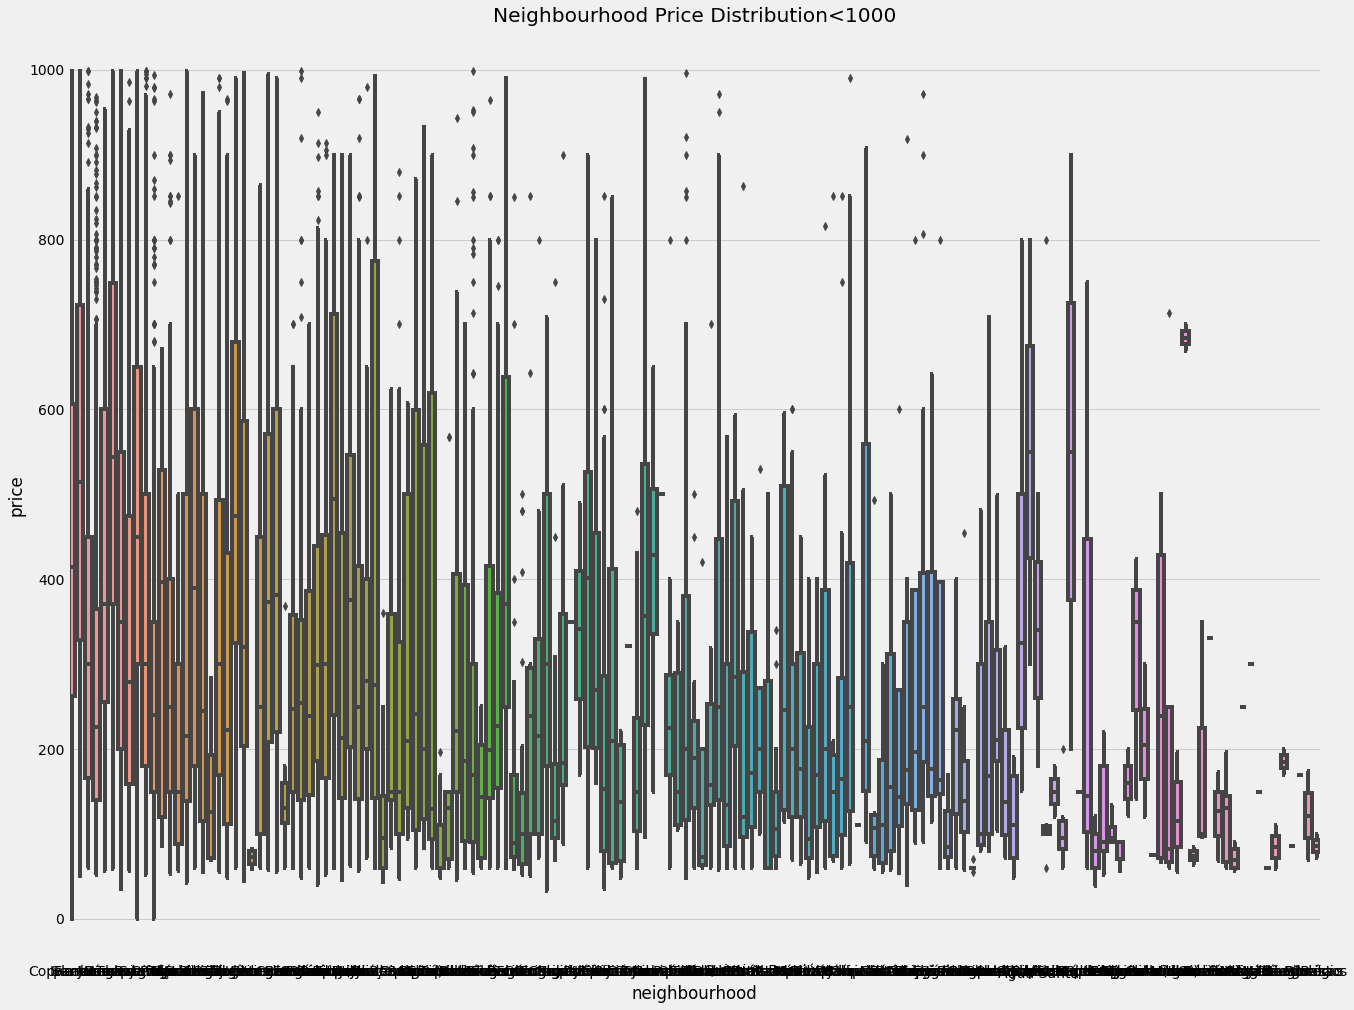

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,16))
plt.title("Neighbourhood Price Distribution<1000")
sns.boxplot(y="price", x="neighbourhood", data = df[df.price<1000])
plt.show()

In [ ]:
plt.figure(figsize=(20,16))
plt.title("Type of Room")
sns.countplot(df.room_type, palette="muted")
fig = plt.gcf()
plt.show()

In [ ]:
corr = df.corr(method='kendall')
plt.figure(figsize=(20,16))
plt.title("Correlation Between Different Variables\n")
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
plt.style.use('fast')
plt.figure(figsize=(20,16))
plt.title("Neighbourhood vs. Availability")
sns.boxplot(data=df, x='neighbourhood',y='availability_365',palette="muted")
plt.show()

In [11]:
df.drop('neighbourhood_group', axis=1, inplace=True)
df.drop('license', axis=1, inplace=True)
df.shape

(24549, 16)

In [ ]:
# one-hot-encoding
#df = pd.get_dummies(df)

Seeding and split data

In [12]:
# set seed keeping same random values
seed = 20
# test dataset
df_test = df.sample(frac=0.1, random_state=seed)
# train dataset
df_train = df.drop(df_test.index.tolist())

In [13]:
print(f'test dataset : {df_test.shape}')
print(f'train dataset: {df_train.shape}')

test dataset : (2455, 16)
train dataset: (22094, 16)


In [14]:
print(f'mean price: R${df.price.mean():.2f}')

mean price: R$1029.59


In [13]:
#inlist
feature_list = ['host_id', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [14]:
# set X and y
X = df_train[feature_list]
y = df_train.price
# set train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)
# check dimension
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(19884, 9) (2210, 9) (19884,) (2210,)


In [15]:
# copy datasets
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

In [16]:
# inst alg
le = LabelEncoder()
# train dataset training
le.fit(X_train['room_type'])
# transforming
X_train_enc['room_type'] = le.transform(X_train['room_type'])
X_val_enc['room_type'] = le.transform(X_val['room_type'])
# result
X_train_enc.head(10)

,host_id,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
21674,218732153,-22.960280,-43.170460,0,1,3,0.83,3,270
4377,50389387,-22.973080,-43.185840,0,4,9,0.12,1,359
18615,103275390,-22.986880,-43.189650,0,1,79,5.72,4,202
12805,74338742,-23.003480,-43.340680,2,2,8,0.23,8,75
16217,198473960,-22.973050,-43.190290,0,2,1,0.04,4,260
5405,55248222,-22.917920,-43.179220,2,2,35,0.51,5,305
23370,432880857,-22.961911,-43.180654,0,3,0,0.00,3,362
16461,97513278,-22.934120,-43.194530,0,2,0,0.00,1,0
19867,37776540,-22.982320,-43.208220,2,1,1,0.11,7,208
20622,400317308,-22.764320,-43.109610,0,1,25,3.35,1,360


In [17]:
# inst alg
reg = LinearRegression()
# train selected dataset 
reg.fit(X_train_enc, y_train)
# realizando as previsões tanto nos dados de treino quanto no de validação
y_pred_train = reg.predict(X_train_enc)
y_pred_val = reg.predict(X_val_enc)

print(f'Train data prediction:')
print('-----------------------------------------------------')
print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred_train)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}')
print(f'R2 score: {r2_score(y_train, y_pred_train)}\n')

print(f'Validation data prediction:')
print('-----------------------------------------------------')
print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}')
print(f'R2 score: {r2_score(y_val, y_pred_val)}')

Train data prediction:
-----------------------------------------------------
Mean Squared Error: 32793422.16150046
Mean Absolute Error: 931.2741498560472
R2 score: 0.006404932262896401

Validation data prediction:
-----------------------------------------------------
Mean Squared Error: 10820066.276822075
Mean Absolute Error: 931.2741498560472
R2 score: 0.01798139138014776


In [18]:
# models
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor(n_estimators=1000)
svr = SVR()
LGBM = LGBMRegressor(n_estimators=1000)
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)
gbr = GradientBoostingRegressor(random_state=seed)
etr = ExtraTreesRegressor(n_estimators=1000, random_state=0)

# trained model list
models = [('DECISION TREE', dtr),
          ('RANDOM FOREST', rfr),
          ('LGBM', LGBM),
          ('SVR', svr),
          ('RIDGE', ridge),
          ('LASSO', lasso),
          ('GRADIENT BOOSTING', gbr),
          ('EXTRA TREES', etr)]

# looping for results
for name, model in models:
    model.fit(X_train_enc, y_train)
    y_pred_train = model.predict(X_train_enc)
    y_pred_val = model.predict(X_val_enc)
    
    print(f'{name}')
    print(f'Train data prediction:')
    print('-----------------------------------------------------')
    print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred_train)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}')
    print(f'R2 score: {r2_score(y_train, y_pred_train)}\n')
    
    print(f'Validation data prediction:')
    print('-----------------------------------------------------')
    print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred_val)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_pred_val)}')
    print(f'R2 score: {r2_score(y_val, y_pred_val)}')
    
    print()
    print()

DECISION TREE
Train data prediction:
-----------------------------------------------------
Mean Squared Error: 0.0
Mean Absolute Error: 0.0
R2 score: 1.0

Validation data prediction:
-----------------------------------------------------
Mean Squared Error: 21097008.900452487
Mean Absolute Error: 912.5601809954751
R2 score: -0.9147438468877755


RANDOM FOREST
Train data prediction:
-----------------------------------------------------
Mean Squared Error: 5535281.601796614
Mean Absolute Error: 324.069913347415
R2 score: 0.8322886684105247

Validation data prediction:
-----------------------------------------------------
Mean Squared Error: 9685457.334648505
Mean Absolute Error: 754.9516900452488
R2 score: 0.12095738674051826


LGBM
Train data prediction:
-----------------------------------------------------
Mean Squared Error: 3846318.926245917
Mean Absolute Error: 656.6910587692709
R2 score: 0.8834618877151382

Validation data prediction:
------------------------------------------------

Selecting Random Forest due to better results on the tests

In [19]:
# total tree 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# variables
max_features = ['auto', 'sqrt']
# levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# node sample
min_samples_split = [2, 5, 10]
# leaf node sample
min_samples_leaf = [1, 2, 4]
# method 
bootstrap = [True, False]
# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha':[0.0, 0.1, 0.2]}
pprint(random_grid)

{'bootstrap': [True, False],
 'ccp_alpha': [0.0, 0.1, 0.2],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [ ]:
# inst alg
rf = RandomForestRegressor()
# parameters search 4 cross-fold in 200
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=0, random_state=seed, n_jobs = -1)
# train with RandomSearch
rf_random.fit(X_train_enc, y_train)

In [ ]:
# set best param
rf_random.best_params_

In [ ]:
# best hyperparameters
best_random = rf_random.best_estimator_

In [ ]:
# train with chosen hiperparameter
best_random.fit(X_train_enc, y_train)

In [ ]:
# predictions
y_pred_train = best_random.predict(X_train_enc)
y_pred_val = best_random.predict(X_val_enc)

print(f'Train dataset prediction:')
print('-----------------------------------------------------')
print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred_train)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}')
print(f'R2 score: {r2_score(y_train, y_pred_train)}\n')

print(f'Validation dataset prediction:')
print('-----------------------------------------------------')
print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_pred_val)}')
print(f'R2 score: {r2_score(y_val, y_pred_val)}')